# EEG data exploration

## EEG preprocessing steps

1. Splitting the files into Infant and Mother data files 
2. Renaming the channels and removing flat electrodes
3. Filtering the data using a 1-30 Hz bandpass and 60 Hz notch filtering 
4. Downsampling the data
5. ICA + CORRMAP to create a template for another participant - in progress
6. AutoReject <br>


Based on:
- Turk, E., Endevelt-Shapira, Y., Feldman, R., Van Den Heuvel, M. I., & Levy, J. I. (2022b). Brains in Sync: Practical Guideline for Parent–Infant EEG During Natural Interaction. Frontiers in Psychology, 13. <br>
- Endevelt-Shapira, Y., & Feldman, R. (2023). Mother & Infant Brain-to-Brain Synchrony Patterns Reflect Caregiving Profiles. Biology, 12(2).

### Resources:

Filtering and downsampling: https://mne.tools/0.15/auto_tutorials/plot_artifacts_correction_filtering.html <br>
Preprocessing with MNE: https://mne.tools/dev/auto_tutorials/intro/10_overview.html <br>
ICA (fastica + corrmap): https://mne.tools/dev/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica <br>
ICA https://labeling.ucsd.edu/tutorial/labels <br>

### Load libraries

In [1]:
# Core 
import io

# Data Science
import numpy as np
import scipy 
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

# MNE 
import mne

# HyPyP
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

# From Mother-InfantEEG_complete notebook
import os
from copy import copy
from collections import OrderedDict
from mne.datasets import eegbci
from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference

# other
from copy import copy

### Read Raw Data

In [2]:
def read_data(path):
    if path[-4:] == ".bdf":
        data = mne.io.read_raw_bdf(path, preload = True)
        return data
    elif path[-4:] == ".fif":
        data = mne.io.read_raw_fif(path, preload = True)
        return data

### Separate Files

In [3]:
import re 

# Separate the dyad file into mother and infant files

# Identify the channels corresponding to each person
def identify_person(dyad_data):
    r_i = re.compile("^1-")
    r_m = re.compile("^2-")
    infant_channels = [chan for chan in list(filter(r_i.match, dyad_data.info["ch_names"])) if "EMPTY" not in chan]
    mother_channels = [chan for chan in list(filter(r_m.match, dyad_data.info["ch_names"])) if "EMPTY" not in chan]

    return infant_channels, mother_channels

# Create and save mother and infant data in two separate files
def separate_files(dyad_path, i_channels, m_channels):
    dyad_data = read_data(dyad_path)
    idx = re.findall(r'\d+', str(dyad_path))[0]
    infant_path = f"Infant{idx}_RestingState.fif"
    mother_path = f"Mother{idx}_RestingState.fif"
    infant_file = dyad_data.save(infant_path, i_channels, overwrite = True)
    mother_file = dyad_data.save(mother_path, m_channels, overwrite = True)
    return infant_file, mother_file, infant_path, mother_path

### Rename channels

In [4]:
def rename_channel_names(data):
    old_channels = list(filter(lambda x: "EMPTY" not in x, data.info["ch_names"]))
    new_channels = [chan[2::] if chan[0:2] == "1-" or chan[0:2] == "2-" else chan for chan in old_channels]
    old_to_new_names = {}
    for old, new in zip(old_channels, new_channels):
        old_to_new_names[old] = new


    data.rename_channels(mapping = old_to_new_names)
    
    return data

### Create separate files for mother and infant

In [5]:
def main(dyad_path):
    dyad_data = read_data(dyad_path)
    infant_channels, mother_channels = identify_person(dyad_data)
    infant_file, mother_file, infant_path, mother_path = separate_files(dyad_path, infant_channels, mother_channels)
    infant_data = read_data(infant_path)
    mother_data = read_data(mother_path)
    rename_channel_names(infant_data)
    rename_channel_names(mother_data)
    return infant_file, mother_file, dyad_data, infant_data, mother_data

infant_file, mother_file, dyad_data, rawInfant, rawMom = main("/home/agata/Desktop/thesis/Dyad01_RestingState1.bdf")

Extracting EDF parameters from /home/agata/Desktop/thesis/Dyad01_RestingState1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385023  =      0.000 ...   188.000 secs...


/tmp/ipykernel_17693/57864750.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'1-EMPTY', '2-EMPTY'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_bdf(path, preload = True)


Extracting EDF parameters from /home/agata/Desktop/thesis/Dyad01_RestingState1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 385023  =      0.000 ...   188.000 secs...


/tmp/ipykernel_17693/57864750.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'1-EMPTY', '2-EMPTY'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_bdf(path, preload = True)


Overwriting existing file.
Writing /home/agata/Desktop/thesis/Infant01_RestingState.fif


/tmp/ipykernel_17693/3326202749.py:20: RuntimeWarning: This filename (/home/agata/Desktop/thesis/Infant01_RestingState.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  infant_file = dyad_data.save(infant_path, i_channels, overwrite = True)


Closing /home/agata/Desktop/thesis/Infant01_RestingState.fif
[done]
Overwriting existing file.
Writing /home/agata/Desktop/thesis/Mother01_RestingState.fif


/tmp/ipykernel_17693/3326202749.py:21: RuntimeWarning: This filename (/home/agata/Desktop/thesis/Mother01_RestingState.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mother_file = dyad_data.save(mother_path, m_channels, overwrite = True)


Closing /home/agata/Desktop/thesis/Mother01_RestingState.fif
[done]
Opening raw data file Infant01_RestingState.fif...
Isotrak not found
    Range : 0 ... 385023 =      0.000 ...   188.000 secs
Ready.
Reading 0 ... 385023  =      0.000 ...   188.000 secs...


/tmp/ipykernel_17693/57864750.py:6: RuntimeWarning: This filename (Infant01_RestingState.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(path, preload = True)


Opening raw data file Mother01_RestingState.fif...
Isotrak not found
    Range : 0 ... 385023 =      0.000 ...   188.000 secs
Ready.
Reading 0 ... 385023  =      0.000 ...   188.000 secs...


/tmp/ipykernel_17693/57864750.py:6: RuntimeWarning: This filename (Mother01_RestingState.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(path, preload = True)


### Set Parameters

In [6]:
# Setting parameters

# Frequency bands used in the study
freq_bands = {
    "Theta": [4, 7],
    "Alpha-Low": [6, 9], #Baby-alpha e.g., Marshall 2002;Santamaria 2020
    "Alpha-High": [11.5, 13],
    "Beta": [13.5, 29.5],
    "Gamma": [30, 48],
}
freq_bands = OrderedDict(freq_bands)  # Force to keep order

# Specify sampling frequency
sampling_rate = 2048  # Hz

### Drop flat electrodes

In [7]:
# Drop reference channels 'M1', 'M2' and heartrate channels 'HR1', 'HR2'
rawInfant.drop_channels(['M1', 'M2', 'HR1', 'HR2'])
rawMom.drop_channels(['M1', 'M2', 'HR1', 'HR2'])

<Raw | Mother01_RestingState.fif, 64 x 385024 (188.0 s), ~188.1 MB, data loaded>

### Set channels locations

In [8]:
# Set montage to 'biosemi64', 'BioSemi cap with 64 electrodes (64+3 locations)'

rawInfant.set_montage('biosemi64') 
rawMom.set_montage('biosemi64')

<Raw | Mother01_RestingState.fif, 64 x 385024 (188.0 s), ~188.1 MB, data loaded>

## Filter the data

In [9]:
# Filter using 1-30 Hz bandpass and notch filter 60 Hz
fmin = 1
fmax = 30

rawInfant_filtered = rawInfant.copy().notch_filter(60)
rawMom_filtered = rawMom.copy().notch_filter(60)

rawInfant_filtered = rawInfant_filtered.filter(fmin, fmax, picks='eeg', method='fir')
rawMom_filtered = rawMom_filtered.filter(fmin, fmax, picks='eeg', method='fir')

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.9s finished


## Downsample the data

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.010 (s)


/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


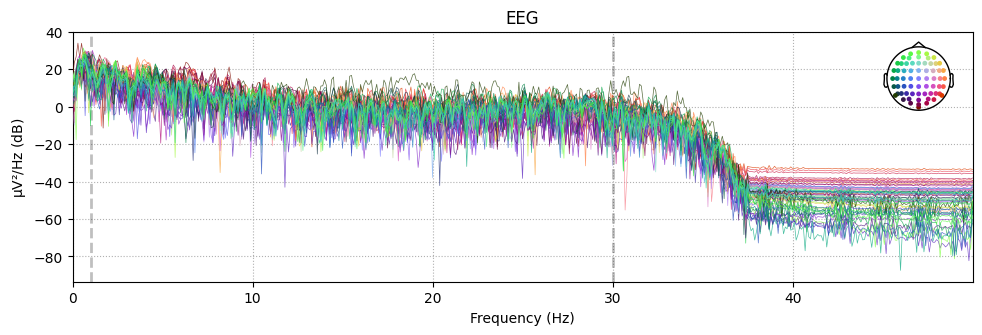

In [10]:
rawInfant_filtered = rawInfant_filtered.resample(100, npad="auto")  # set sampling frequency to 100Hz
rawMom_filtered = rawMom_filtered.resample(100, npad="auto")  # set sampling frequency to 100Hz
rawInfant_filtered.plot_psd(area_mode='range', tmax=10.0);

## Plot the data

Using matplotlib as 2D backend.


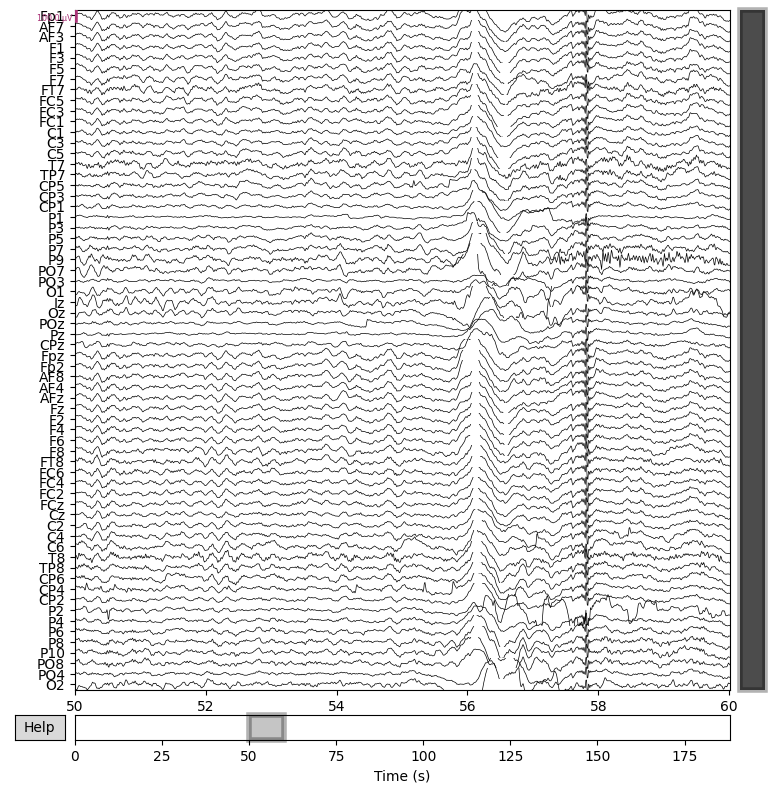

In [11]:
rawInfant_filtered.plot(n_channels = 64, start = 50, scalings = dict(eeg=50e-6));

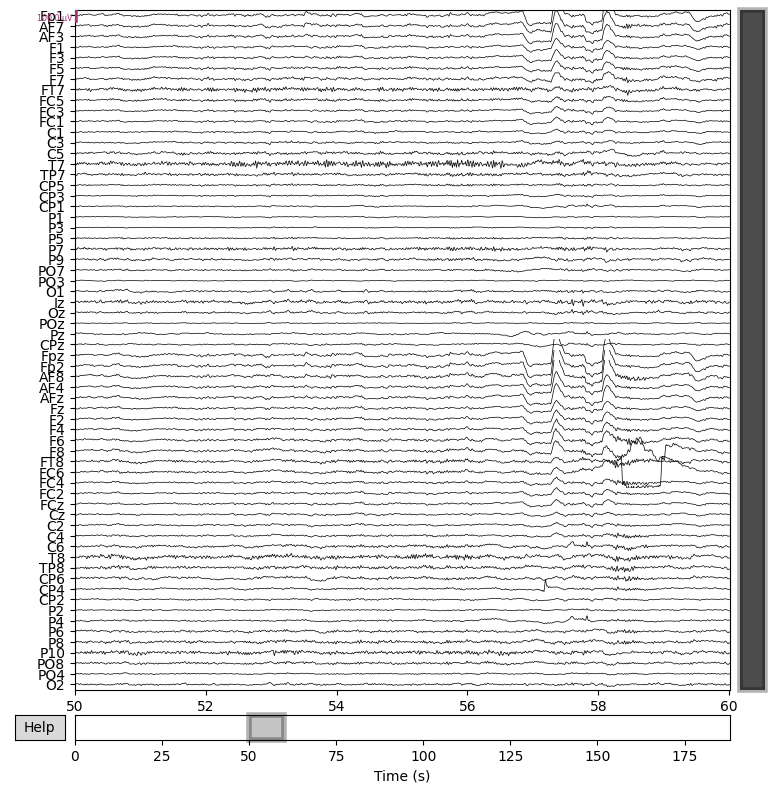

In [12]:
rawMom_filtered.plot(n_channels = 64, start = 50, scalings = dict(eeg=50e-6));

## ICA

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.8s.
Creating RawArray with float64 data, n_channels=15, n_times=18800
    Range : 0 ... 18799 =      0.000 ...   187.990 secs
Ready.


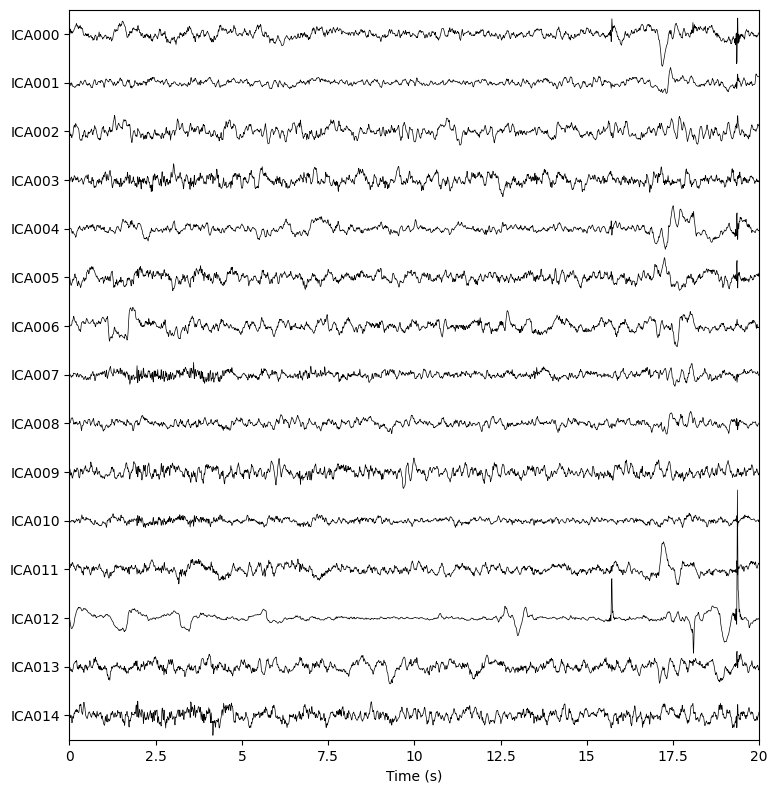

In [21]:
from mne.preprocessing import ICA
# play around with this number to get components 
# that seem to represent the actual brain activations well
num_components = 15 
ica = ICA(n_components=num_components, method='fastica')
ica.fit(rawInfant_filtered)

ica.plot_sources(rawInfant_filtered, show_scrollbars=False);

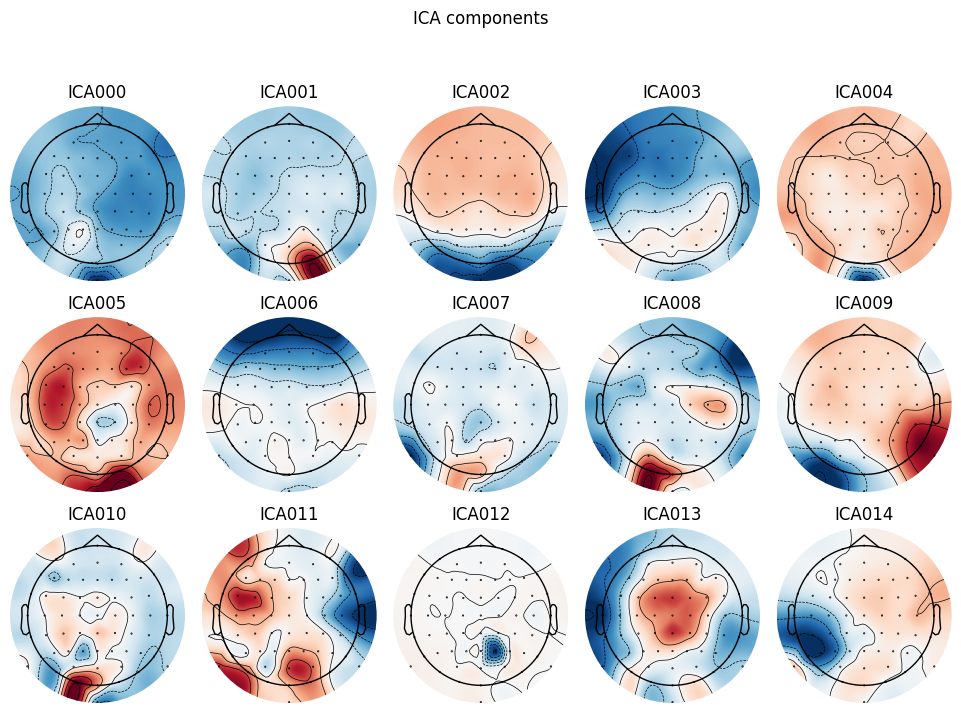

In [23]:
ica.plot_components(ch_type = 'eeg', inst = rawInfant_filtered, sphere = 'eeglab');

One commonly used heuristic is looking at the spectum of each component. Ideally, each spectrum will have a 1/x - like shape …while outlier components will have increasing intensity for higher frequencies

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated


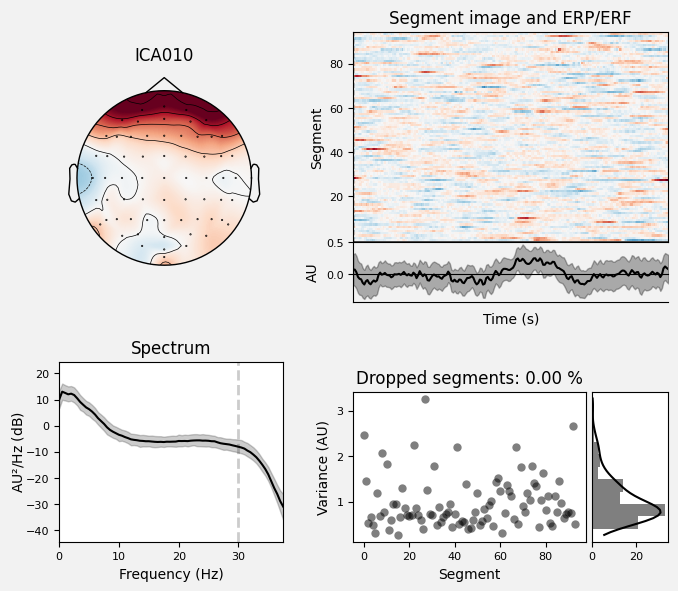

In [39]:
ica.plot_properties(rawInfant, picks=10); # This exact component number probably won't work if you recompute ICA

In [ ]:
# use the first subject as template; use Fpz as proxy for EOG
from mne.preprocessing import corrmap

eog_inds, eog_scores = ica.find_bads_eog(raw, ch_name='Fpz')

corrmap(ica, template=(0, eog_inds[0]))


## Epoch the data
If Autoreject and ICA take too much time, change the decim value (see MNE documentation). Please filter the Epochs between 2 and 30 Hz before ICA fit (mne.Epochs.filter(epoch, 2, 30, method='fir')).

In [41]:

rawEpochsBaby = mne.make_fixed_length_epochs(rawInfant, duration=2.0, preload=True, reject_by_annotation=False)
rawEpochsMom = mne.make_fixed_length_epochs(rawMom, duration=2.0, preload=True, reject_by_annotation=False)


# Downsample the data to reduce the computation time. Using a 512 Hz rate or higher should be enough 
# for most high frequency analyses (Turk et al., 2022). 
# MNE also provides the convenience methods mne.Epochs.resample() 
# and mne.Evoked.resample() to downsample or upsample data, but these are less optimal because they will introduce 
# edge artifacts into every epoch, whereas filtering the raw data will only introduce edge artifacts only at the start and end of the recording

print('Original sampling rate:', rawEpochsBaby.info['sfreq'], 'Hz')
rawEpochsBaby.resample(100)
rawEpochsMom.resample(100)
print('New sampling rate:', rawEpochsBaby.info['sfreq'], 'Hz')

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 13517 samples (6.600 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 4096 original time points ...


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.7s finished


0 bad epochs dropped
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 94 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



/tmp/ipykernel_5793/688547960.py:15: RuntimeWarning: filter_length (6759) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  rawEpochsBaby.filter(fmin, fmax, picks='eeg', method='fir')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6759 samples (3.300 sec)



[Parallel(n_jobs=1)]: Done 6016 out of 6016 | elapsed:    5.3s finished
/tmp/ipykernel_5793/688547960.py:17: RuntimeWarning: filter_length (6759) is longer than the signal (4096), distortion is likely. Reduce filter length or filter a longer signal.
  rawEpochsBaby.filter(fmin, fmax, picks='eeg', method='fir')
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6016 out of 6016 | elapsed:    5.8s finished


Original sampling rate: 2048.0 Hz
New sampling rate: 100.0 Hz


## Preprocessing epochs

## Preprocessing epochs
## ICA correction

Computing global AutoReject and Independant Components Analysis for each participant

In [42]:
icas = prep.ICA_fit([rawEpochsBaby, rawEpochsMom],
                    n_components=15,
                    method='fastica',
                    fit_params=dict(),
                    random_state= 42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.0002570103190639912}
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.0s.
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P9', 'Iz']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP1', 'P1', 'P5', 'P7', 'P9', 'PO7', 'Iz', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'FT8', 'T8', 'TP8', 'CP6', 'P2', 'P6', 'P8', 'P10', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['Iz']
    Rejecting  epoch based on EEG : ['P9', 'PO7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : 

/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/hypyp/prep.py:181: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  random_state=random_state).fit(epoch)


Selecting by number: 15 components
Fitting ICA took 14.7s.
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz']
    Rejecting  epoch based on EEG : ['Fpz', 'AF8', 'FC6', 'CP6']
    Rejecting  epoch based on EEG : ['Fp1', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fpz', 'Fp2']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['CP6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'Fpz', 'Fp2', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF3', 'F5', 'Fpz', 'Fp2', 'AF8', 'AFz']
    Rejecting  epoch based on EEG : ['FC6']
    Rejecting  epoch based on EEG : ['Fpz', 'AF8']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8', 'CP6']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'Fp2', 'AF8', 'F8']
    Rejecting  epoch based on EEG : ['Fpz']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'Fpz', 'F

/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/hypyp/prep.py:186: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  icas.append(ica.fit(epoch_all_ch))


Fitting ICA took 0.6s.


Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both.

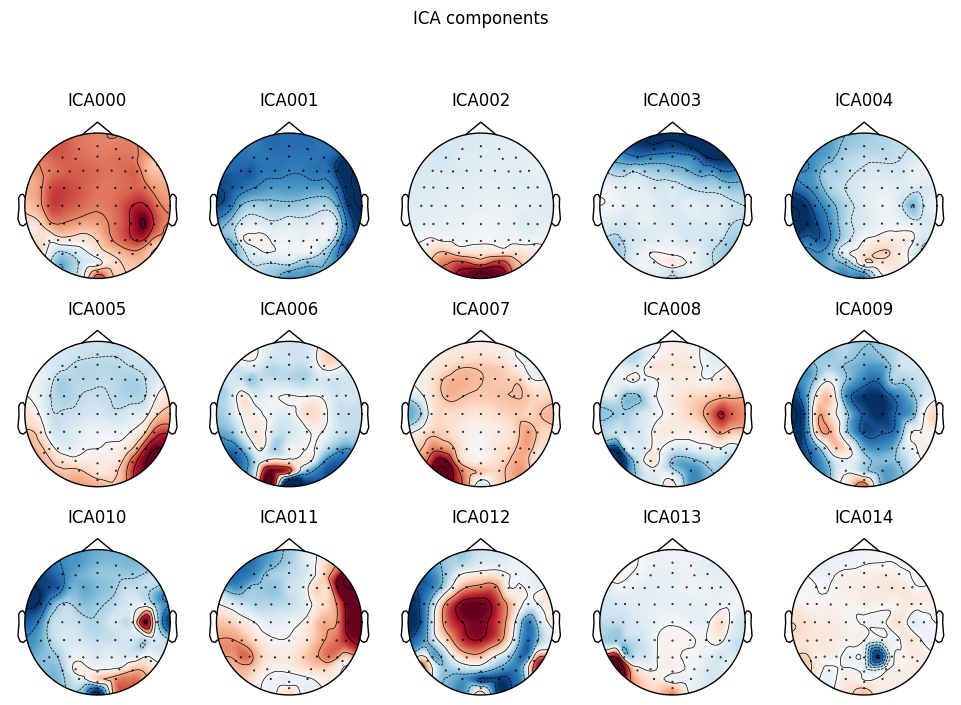

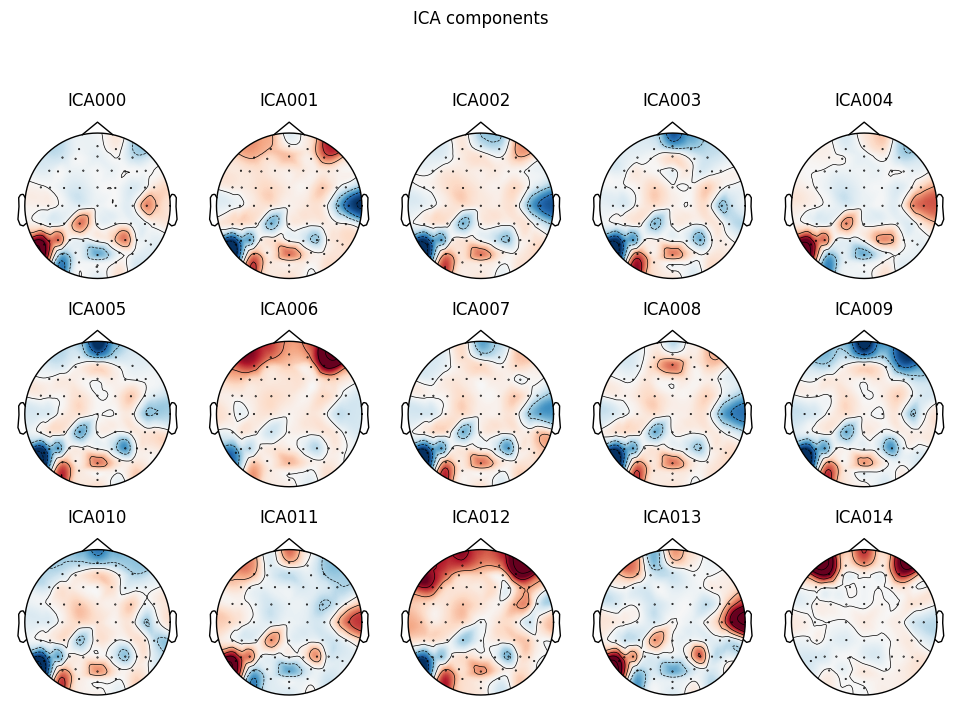

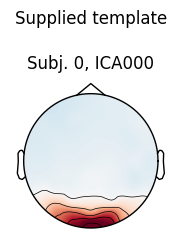

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [1], consider a more liberal threshold.


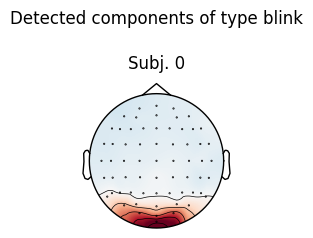

[{'blink': [2]}, {'blink': []}]
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


In [43]:
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [rawEpochsBaby, rawEpochsMom])

## Autoreject
Applying local AutoReject for each participant rejecting bad epochs, rejecting or interpolating partially bad channels removing the same bad channels and epochs across participants plotting signal before and after (verbose=True) <br><br>
With ICA components

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.10 and n_interpolate=1
Dropped 81 epochs: 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93


  0%|          | Repairing epochs : 0/13 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 81 epochs: 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93


  0%|          | Repairing epochs : 0/13 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
86.17021276595744 percent of bad epochs


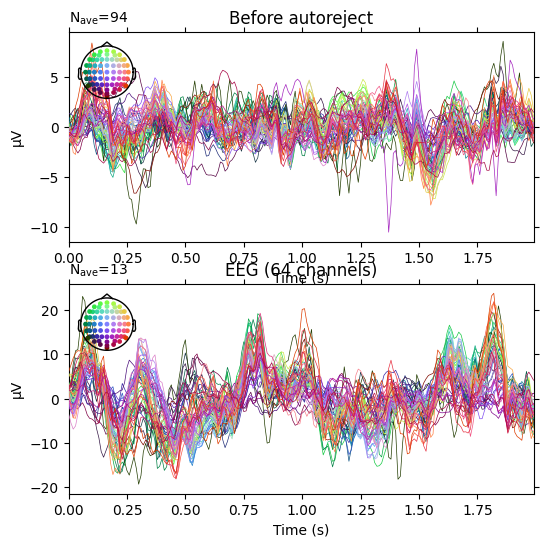

<Figure size 640x480 with 0 Axes>

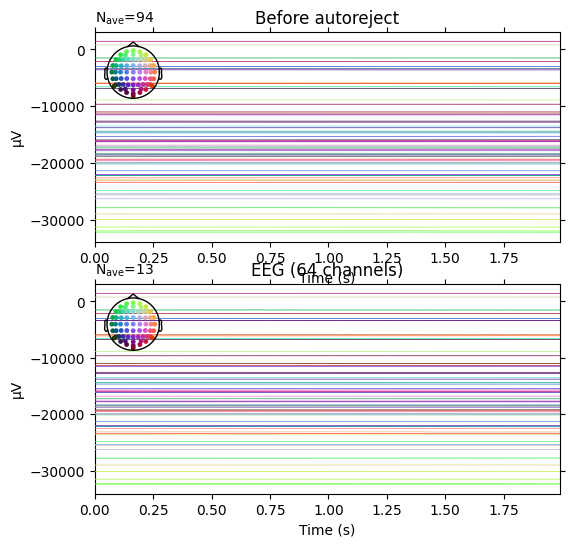

In [44]:
# with ICA

cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Without ICA components 

In [14]:
from autoreject import AutoReject
ar = AutoReject()
rawEpochsBaby_clean = ar.fit_transform(rawEpochsBaby)
rawEpochsMom_clean = ar.fit_transform(rawEpochsMom)  

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

In [12]:
# without ICA

cleaned_epochs_no_ICA = [rawEpochsBaby_resampled, rawEpochsMom_resampled]

no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=32
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/94 [00:00<?,       ?it/s]

### Serialize and deserialize data
So you don't have to run the AutoReject every time the kernel crashes

In [13]:
import pickle

# Saving the objects:
with open('autoreject_vars.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([rawEpochsBaby_clean, rawEpochsMom_clean], f)

In [ ]:
# Getting back the objects:

with open('autoreject_vars.pkl') as f:  # Python 3: open(..., 'rb')
    rawEpochsBaby_clean, rawEpochsMom_clean = pickle.load(f)

### Picking the preprocessed epochs for each participant

In [45]:
# with ICA
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

# Picking the preprocessed epochs for each participant
#preproc_S1 = rawEpochsBaby
#preproc_S2 = rawEpochsMom

In [14]:
# without ICA

no_ICA_preproc_S1 = rawEpochsBaby_clean 
no_ICA_preproc_S2 = rawEpochsMom_clean

## Analysing data
### Welch Power Spectral Density
Here for ex, the frequency-band-of-interest is restricted to Alpha_Low, frequencies for which power spectral density is actually computed are returned in freq_list, and PSD values are averaged across epochs

In [46]:
# without ICA

# no_ICA_psd1 = analyses.pow(preproc_S1, fmin=freq_bands["Alpha-Low"][0], fmax=freq_bands["Alpha-Low"][1],
#                     n_fft=1000, n_per_seg=1000, epochs_average=True)
# no_ICA_psd2 = analyses.pow(preproc_S2, fmin=freq_bands["Alpha-Low"][0], fmax=freq_bands["Alpha-Low"][1],
#                     n_fft=1000, n_per_seg=1000, epochs_average=True)
# no_ICA_data_psd = np.array([no_ICA_psd1.psd, no_ICA_psd2.psd])

psd1 = analyses.pow(
    preproc_S1, fmin=freq_bands["Alpha-Low"][0], fmax=freq_bands["Alpha-Low"][1], n_fft=1000, n_per_seg=1000, epochs_average=True
)
psd2 = analyses.pow(
    preproc_S2, fmin=freq_bands["Alpha-Low"][0], fmax=freq_bands["Alpha-Low"][1], n_fft=1000, n_per_seg=1000, epochs_average=True
)
data_psd = np.array([psd1.psd, psd2.psd])


Effective window size : 10.000 (s)
Effective window size : 10.000 (s)


### Connectivity
Initializing data and storage

In [47]:
# with ICA
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

print(data_inter.shape)

(2, 13, 64, 200)


In [16]:
# without ICA
no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])

Computing analytic signal per frequency band

In [48]:
# with ICA
modified_srate = 100
complex_signal = analyses.compute_freq_bands(data_inter, modified_srate, freq_bands)

In [17]:
# without ICA
no_ICA_complex_signal = analyses.compute_freq_bands(no_ICA_data_inter, sampling_rate, freq_bands)

: 

: 

Computing frequency- and time-frequency-domain connectivity, 'ccorr' for example

In [49]:
resultCcorr = analyses.compute_sync(complex_signal, mode='ccorr')
result = analyses.compute_sync(complex_signal, mode="plv")

Slicing results to get the Inter-brain part of the matrix

In [51]:
# slicing results to get the Inter-brain part of the matrix
n_ch = len(rawMom.info["ch_names"]) #need to change it to common channel names
theta, alpha_low, alpha_high, beta, gamma = result[:, 0:n_ch, n_ch: 2 * n_ch]

Choosing Alpha_Low for further analyses for example

In [52]:
values = alpha_low
values -= np.diag(np.diag(values))

Computing Cohens'D for further analyses for example

In [53]:
C = (values - np.mean(values[:])) / np.std(values[:])

dataPathBaby = "Infant01_RestingState.fif"
dataPathBaby = "Mother01_RestingState.fif"

scipy.io.savemat("T035_RestingState_PLV.mat",{'PLV': result,'Ccorr':resultCcorr,'dataPathBaby':dataPathBaby,'dataPathMom':dataPathMom,'freq_bands':freq_bands, 'alpha_low':alpha_low, 'C':C})


Slicing results to get the Intra-brain part of the matrix

In [31]:
for i in [0, 1]:
    theta, alpha_low, alpha_high, beta, gamma = result[:, i: i + n_ch, i: i + n_ch]
    # choosing Alpha_Low for further analyses for example
    values_intra = alpha_low
    values_intra -= np.diag(np.diag(values_intra))
    # computing Cohens'D for further analyses for example
    C_intra = (values_intra - np.mean(values_intra[:])) / np.std(values_intra[:])
    # can also sample CSD values directly for statistical analyses
    result_intra.append(C_intra)

Computing frequency- and time-frequency-domain connectivity measures obtained by MVARICA approach, based on MVAR models' coefficients. For instance: PDC measure, with MVAR model of order 2, extended infomax ICA method and checking the MVAR model stability.

In [32]:
# here n_ftt = 512
mvar_result = analyses.compute_conn_mvar(complex_signal = complex_signal,
                                         mvar_params={"mvar_order": 2, "fitting_method": "default", "delta": 0},
                                         ica_params={"method": "infomax_extended", "random_state": None},
                                         measure_params={"name": "pdc", "n_fft": 100}
                                         )

print(mvar_result)

MVAR model is not stable: number of time samples may be too small!


At least 32768 samples are required for fitting MVAR model.


None


Slicing results to get the Inter-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

In [33]:
for i in [0, 1]:
    mvar_result_q = mvar_result.squeeze()
    if i == 0:
        mvar_theta, mvar_alpha_low, mvar_alpha_high, mvar_beta, mvar_gamma = mvar_result[:, n_ch:n_ch * 2, 0:n_ch, :]
    else:
        mvar_theta, mvar_alpha_low, mvar_alpha_high, mvar_beta, mvar_gamma = mvar_result[:, 0:n_ch, n_ch:n_ch * 2, :]
    # choosing Alpha_Low for further analyses for example
    auxiliary = np.zeros((n_ch, n_ch), dtype=mvar_result.dtype)
    for j in range(0, n_ch):
        for k in range(0, n_ch):
            auxiliary[j, k] = np.amax(mvar_alpha_low[j, k])
    mvar_values_inter = auxiliary
    # computing Cohens'D for further analyses for example
    mvar_C_inter = (mvar_values_inter -
                    np.mean(mvar_values_inter[:])) / np.std(mvar_values_inter[:])

AttributeError: 'NoneType' object has no attribute 'squeeze'

## Statistical analyses
### Comparing PSD values to random signal
Parametric t test

#### 1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension

In [34]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(
    X=X, n_permutations=5000, tail=0, n_jobs=1
)

Permuting 1 times (exact test)...


### 2/ HyPyP parametric t test with FDR correction<br> 
based on MNE function, the same things as above are true. FDR correction for multiple comparisons is added.

In [36]:
statsCondTuple = stats.statsCond(
    data=data_psd,
    epochs=preproc_S1,
    n_permutations=5000,
    alpha=0.05,
)

Permuting 1 times (exact test)...


#### 3/ Non-parametric cluster-based permutations¶
Creating matrix of a priori connectivity between channels across space and frequencies based on their position, in the Alpha_Low band for example

In [37]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq
# constitute two artificial groups with 2 'participant1' and 2 'participant1'
data_group = [np.array([psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd])]
statscondCluster = stats.statscondCluster(
    data=data_group,
    freqs_mean=psd1.freq_list,
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
    tail=0,
    n_permutations=5000,
    alpha=0.05,
)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64
Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering …
Found 1 cluster


/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,
/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/mne/stats/parametric.py:170: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

### Comparing Intra-brain connectivity values between participants¶
With 3/ non-parametric cluster-based permutations creating matrix of a priori connectivity between channels across space and frequencies based on their position

In [38]:
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1, freqs_mean=np.arange(7.5, 11), draw=False
)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [39]:
ch_con = con_matrixTuple.ch_con

constitute two artificial groups with 2 'participant1' and 2 'participant2'
in Alpha_Low band for example (see above)

In [41]:
Alpha_Low = [
    np.array([result_intra[0], result_intra[0]]),
    np.array([result_intra[1], result_intra[1]]),
]

statscondCluster_intra = stats.statscondCluster(
    data=Alpha_Low,
    freqs_mean=np.arange(7.5, 11),
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
    tail=0,
    n_permutations=5000,
    alpha=0.05,
)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering …


/home/agata/Desktop/thesis/.venv/lib/python3.10/site-packages/hypyp/stats.py:337: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(data,


Found 1 cluster


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

KeyboardInterrupt: 

### Comparing Inter-brain connectivity values to random signal¶
No a priori connectivity between channels is considered between the two participants

In Alpha_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [ ]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(
    data=data,
    freqs_mean=np.arange(7.5, 11),
    ch_con_freq=None,
    tail=0,
    n_permutations=5000,
    alpha=0.05,
)

## Visualization

### Visualization of T values for sensors

for 1/ T_obs_plot = T_obs

for 2/ statsCondTuple.T_obs

for 3/ statscondCluster.F_obs_plot

In [ ]:
viz.plot_significant_sensors(T_obs_plot=statsCondTuple.T_obs, epochs=preproc_S1)


### Vizualize T values for significant sensors only

In [ ]:
viz.plot_significant_sensors(T_obs_plot=statsCondTuple.T_obs_plot, epochs=preproc_S1)

### Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [54]:
rawEpochsBaby_resampled.info["bads"] = ["F8", "Fp2", "Cz", "O2"]
rawEpochsMom_resampled.info["bads"] = ["F7", "O1"]

### Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

<Figure size 640x480 with 0 Axes>

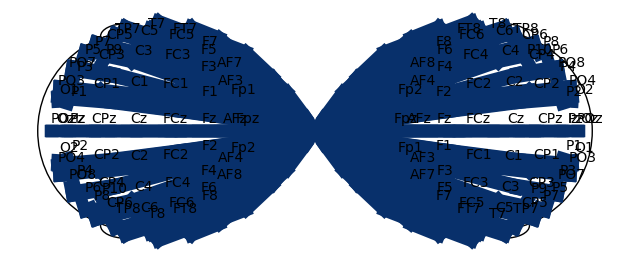

<AxesSubplot: >

In [54]:
viz.viz_2D_topomap_inter(preproc_S1, preproc_S2, C, threshold=3, steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

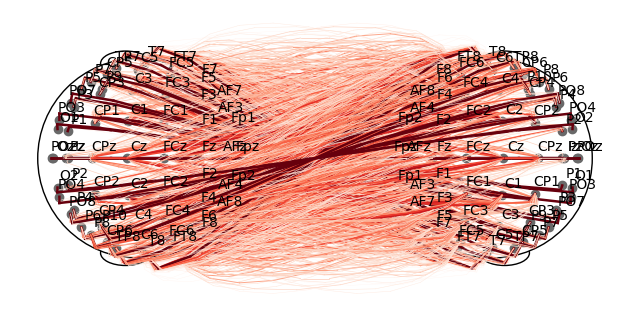

<AxesSubplot: >

In [57]:
viz.viz_2D_topomap_inter(preproc_S1, preproc_S2, result[0], threshold='auto', steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

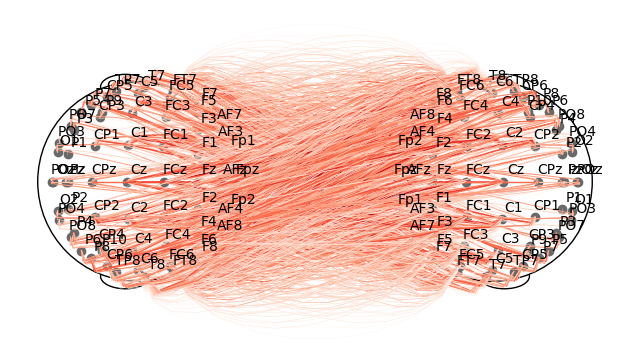

<AxesSubplot: >

In [44]:
viz.viz_2D_topomap_inter(preproc_S1, preproc_S2, result[1], threshold='auto', steps=10, lab=True)

# Questions

- Should I do the ICA on Raw or Epoched data? Or do both and compare? <br>
- When should I use AutoReject?